<a href="https://colab.research.google.com/github/nedokormysh/GB_Libraries_python_for_DS_2/blob/CourseProject/CourseworkDirtyDrop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Постановка задачи<a class="anchor" id="course_project_task"></a>

**Задача**

На основании имеющихся данных о клиентах банка требуется построить модель для прогнозирования невыполнения долговых обязательств по текущему кредиту, используя обучающий датасет. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1($\beta$ = 1) > 0.5 при Precision > 0.5 и Recall > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

## Примерное описание этапов выполнения курсового проекта<a class="anchor" id="course_project_steps"></a>

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

## Обзор данных<a class="anchor" id="course_project_review"></a>

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

# Подключение библиотек и загрузка данных<a class="anchor" id="load_data"></a>

In [1]:
pip install catboost

     |████████████████████████████████| 76.6 MB 45 kB/s 


In [3]:
import pandas as pd
import numpy as np
import pickle


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from scipy.stats import chi2_contingency
import xgboost as xgb
import catboost as catb


from scipy.stats import shapiro, probplot, mannwhitneyu

In [4]:
"""Отчет с метриками модели"""
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [5]:
TRAIN_DATASET_PATH = 'https://raw.githubusercontent.com/nedokormysh/GB_Libraries_python_for_DS_2/CourseProject/course_project_train.csv'
TEST_DATASET_PATH = 'https://raw.githubusercontent.com/nedokormysh/GB_Libraries_python_for_DS_2/CourseProject/course_project_test.csv'

#**Построение модели классификации**

## 1. Обзор обучающего датасета.

In [6]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.columns = [x.replace(" ", "_") for x in df_train.columns]
df_train.head().T

,0,1,2,3,4
Home_Ownership,Own Home,Own Home,Home Mortgage,Own Home,Rent
Annual_Income,482087.0,1025487.0,751412.0,805068.0,776264.0
Years_in_current_job,NaN,10+ years,8 years,6 years,8 years
Tax_Liens,0.0,0.0,0.0,0.0,0.0
Number_of_Open_Accounts,11.0,15.0,11.0,8.0,13.0
Years_of_Credit_History,26.3,15.3,35.0,22.5,13.6
Maximum_Open_Credit,685960.0,1181730.0,1182434.0,147400.0,385836.0
Number_of_Credit_Problems,1.0,0.0,0.0,1.0,1.0
Months_since_last_delinquent,NaN,NaN,NaN,NaN,NaN
Bankruptcies,1.0,0.0,0.0,1.0,0.0


Проверка на дубликаты.

In [11]:
df_train.duplicated().value_counts()

False    7500
dtype: int64

Общая информация о датасете.

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home_Ownership                7500 non-null   object 
 1   Annual_Income                 5943 non-null   float64
 2   Years_in_current_job          7129 non-null   object 
 3   Tax_Liens                     7500 non-null   float64
 4   Number_of_Open_Accounts       7500 non-null   float64
 5   Years_of_Credit_History       7500 non-null   float64
 6   Maximum_Open_Credit           7500 non-null   float64
 7   Number_of_Credit_Problems     7500 non-null   float64
 8   Months_since_last_delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current_Loan_Amount           7500 non-null   float64
 13  Cur

Существуют пропуски 

1.   Bankruptcies
2.   Credit_Score
3.   Years_in_current_job
4.   Annual_Income
5.   Months_since_last_delinquent



In [12]:
print(f'В обучающейм датафрейме {df_train.shape[0]} строк и {df_train.shape[1]} столбцов')

В обучающейм датафрейме 7500 строк и 17 столбцов


**Признаки датасета.**

In [13]:
nl = '\n'
print(f"Названия столбцов в обучающем датафрейме: {nl}{df_train.columns}")

Названия столбцов в обучающем датафрейме: 
Index(['Home_Ownership', 'Annual_Income', 'Years_in_current_job', 'Tax_Liens',
       'Number_of_Open_Accounts', 'Years_of_Credit_History',
       'Maximum_Open_Credit', 'Number_of_Credit_Problems',
       'Months_since_last_delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current_Loan_Amount', 'Current_Credit_Balance', 'Monthly_Debt',
       'Credit_Score', 'Credit_Default'],
      dtype='object')


**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [14]:
target = 'Credit_Default'

num_feat = list(df_train.select_dtypes(exclude='object').columns)
nom_feat = list(df_train.select_dtypes(include='object').columns)
print(f'Числовые признаки: {num_feat}')
print(f'Номинативные признаки: {nom_feat}')
print(f'Целевая переменная: {target}')

Числовые признаки: ['Annual_Income', 'Tax_Liens', 'Number_of_Open_Accounts', 'Years_of_Credit_History', 'Maximum_Open_Credit', 'Number_of_Credit_Problems', 'Months_since_last_delinquent', 'Bankruptcies', 'Current_Loan_Amount', 'Current_Credit_Balance', 'Monthly_Debt', 'Credit_Score', 'Credit_Default']
Номинативные признаки: ['Home_Ownership', 'Years_in_current_job', 'Purpose', 'Term']
Целевая переменная: Credit_Default


### Обзор целевой переменной

Распределение значений целевой переменной

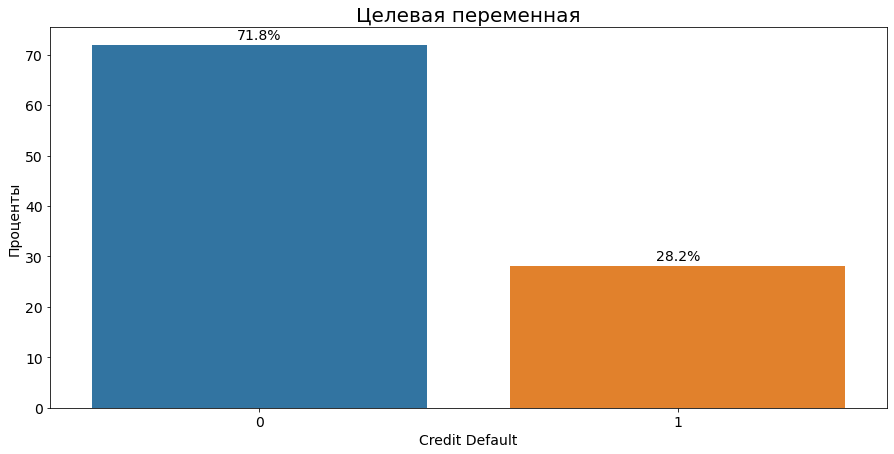

In [16]:
# нормирование на размер датасета
norm_target = (df_train.Credit_Default.value_counts(normalize=True).mul(100).rename('percent').reset_index())

plt.figure(figsize=(15, 7))
ax = sns.barplot(x='index', y='percent', data=norm_target)

# Вывод значений над графиками - annotate()
# В цикле смотрим каждый столбец графика и на нем отмечаем значения
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # текст
                (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
                ha='center', # центрирование
                va='center',
                xytext=(0, 10),
                textcoords='offset points', # точка смещения относительно координаты
                fontsize=14)

plt.title('Целевая переменная', fontsize=20)

plt.xlabel('Credit Default', fontsize=14)
plt.ylabel('Проценты', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

В датесете присутствует дисбаланс классов, при обучении модели это стоит учитывать.  Определим дисбаланс целевой переменной.

In [15]:
disbalance = df_train['Credit_Default'].value_counts()[0] / df_train['Credit_Default'].value_counts()[1]
disbalance

2.549455750118315

### Номинативные признаки.

In [ ]:
def nom_feat_value_counts(nom_feat):
  for el in range(0, len(nom_feat)):
    print('\033[1m' + f'Уникальные значения номинативного признака {nom_feat[el]}:{nl * 2}'
     + '\033[0m' + f'{df_train[nom_feat[el]].value_counts()}{nl}')
    print('-' * 80)

nom_feat_value_counts(nom_feat)

Уникальные значения номинативного признака Home_Ownership:

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home_Ownership, dtype: int64

--------------------------------------------------------------------------------
Уникальные значения номинативного признака Years_in_current_job:

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years_in_current_job, dtype: int64

--------------------------------------------------------------------------------
Уникальные значения номинативного признака Purpose:

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
weddi

Заменим номинативный признак Years_in_current_job на числовые значения.

In [ ]:
years_job_dict = {'< 1 year': 0,
                  '1 year': 1,
                  '2 years': 2,
                  '3 years': 3,
                  '4 years': 4,
                  '5 years': 5,
                  '6 years': 6,
                  '7 years': 7,
                  '8 years': 8,
                  '9 years': 9,
                  '10+ years': 10}

df_train['Years_in_current_job'] = pd.Series(df_train.Years_in_current_job.map(years_job_dict), dtype='int8')

Признак Term принимает всего два значения. Заменим их на 0 и 1.

In [ ]:
term_dict = {'Short Term': 0, 'Long Term': 1}

df_train.Term = pd.Series(df_train.Term.map(term_dict), dtype='int8')

In [ ]:
df_train.head().T

,0,1,2,3,4
Home_Ownership,Own Home,Own Home,Home Mortgage,Own Home,Rent
Annual_Income,482087.0,1025487.0,751412.0,805068.0,776264.0
Years_in_current_job,NaN,10.0,8.0,6.0,8.0
Tax_Liens,0.0,0.0,0.0,0.0,0.0
Number_of_Open_Accounts,11.0,15.0,11.0,8.0,13.0
Years_of_Credit_History,26.3,15.3,35.0,22.5,13.6
Maximum_Open_Credit,685960.0,1181730.0,1182434.0,147400.0,385836.0
Number_of_Credit_Problems,1.0,0.0,0.0,1.0,1.0
Months_since_last_delinquent,NaN,NaN,NaN,NaN,NaN
Bankruptcies,1.0,0.0,0.0,1.0,0.0


In [ ]:
nom_feat = list(df_train.select_dtypes(include='object').columns)
nom_feat

['Home_Ownership', 'Purpose']

Для дальнейшей работы переведём все номинативные признаки в тип категориальных.

In [ ]:
for colname in nom_feat:
    df_train[colname] = pd.Categorical(df_train[colname])
    
df_train[nom_feat].dtypes

Home_Ownership    category
Purpose           category
dtype: object

In [ ]:
target = 'Credit_Default'
feat =  df_train.columns.drop(target).tolist()
num_feat = list(df_train.select_dtypes(exclude='category').columns)
nom_feat = list(df_train.select_dtypes(include='category').columns)
print(f'Числовые признаки: {num_feat}')
print(f'Категориальные признаки: {nom_feat}')
print(f'Целевая переменная: {target}')

Числовые признаки: ['Annual_Income', 'Years_in_current_job', 'Tax_Liens', 'Number_of_Open_Accounts', 'Years_of_Credit_History', 'Maximum_Open_Credit', 'Number_of_Credit_Problems', 'Months_since_last_delinquent', 'Bankruptcies', 'Term', 'Current_Loan_Amount', 'Current_Credit_Balance', 'Monthly_Debt', 'Credit_Score', 'Credit_Default']
Категориальные признаки: ['Home_Ownership', 'Purpose']
Целевая переменная: Credit_Default


### Числовые признаки.

In [ ]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual_Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.0,1168386.0,1640137.00,1.014934e+07
Years_in_current_job,7129.0,5.880348e+00,3.620092e+00,0.0,3.0,6.0,10.00,1.000000e+01
Tax_Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.0,0.0,0.00,7.000000e+00
Number_of_Open_Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.0,10.0,14.00,4.300000e+01
Years_of_Credit_History,7500.0,1.831747e+01,7.041946e+00,4.0,13.5,17.0,21.80,5.770000e+01
Maximum_Open_Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.5,478159.0,793501.50,1.304726e+09
Number_of_Credit_Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.0,0.0,0.00,7.000000e+00
Months_since_last_delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.0,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.0,0.0,0.00,4.000000e+00
Term,7500.0,2.592000e-01,4.382248e-01,0.0,0.0,0.0,1.00,1.000000e+00



*   Annual_Income - есть пропущенные значения
*   Years_in_current_job - есть пропущенные значения
*   Tax_Liens практически все значения - нули
*   Number of Open Accounts - возможно есть выбросы 
*   Years_of_Credit_History - есть выбросы
*   Maximum_Open_Credit - есть нулевые значения, возможно есть выбросы
*   Current_Loan_Amount - возможно есть выбросы
*   Monthly_Debt - возможно есть выбросы
*   Number_of_Credit_Problems - возможно есть выбросы, и много значений - нули
*   Months_since_last_delinquent - много пропущенных значений
*   Bankruptcies - есть пропуски
*   Credit_Score - много пропусков, корелляция с целевой переменной

**Матрица корреляции между признаками.**

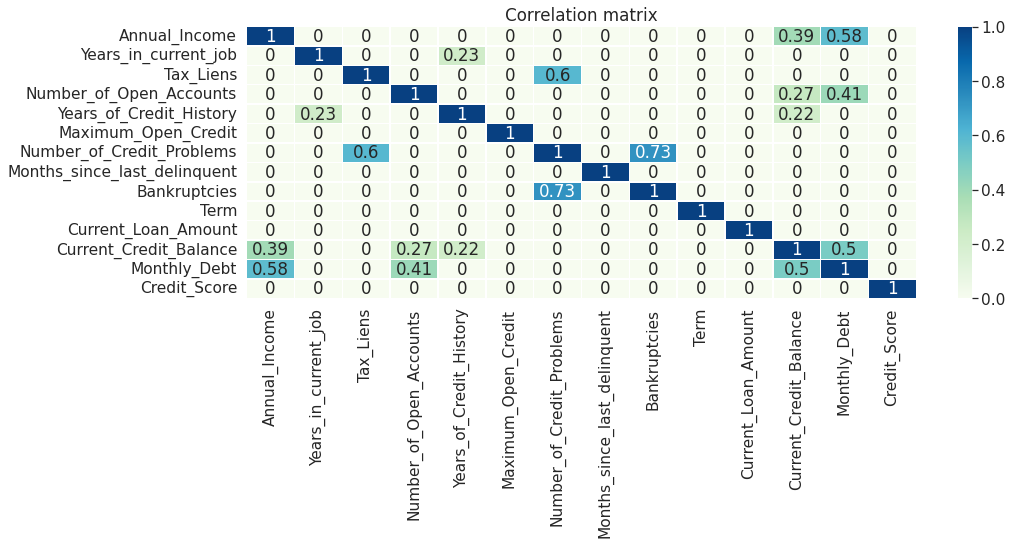

In [ ]:
plt.figure(figsize=(15, 5))

sns.set(font_scale=1.4)

corr_matrix = df_train[feat].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Наблюдаются корреляции между:
*  количеством проблемных кредитов и банкротствами (Number_of_Credit_Problems и Bankruptcies) - 0.73
*  количеством проблемных кредитов и налоговыми обременениями (Number_of_Credit_Problems и Tax_lies) - 0.6
*  месячной задолженностью и годовым доходом (Annual_income и Monthly_Debt) - 0.51
*  текущим кредитным балансом и ежемесячной задолженностью (Current_Credit_Balance и Monthly_Debt) - 0.5
*  годовым доходом и текущим кредитным балансом (Annual_income и Current_Credit_Balance) - 0.34

Определим степень влияния признаков на целевой класс

Text(0.5, 1.0, 'Correlation with TARGET variable')

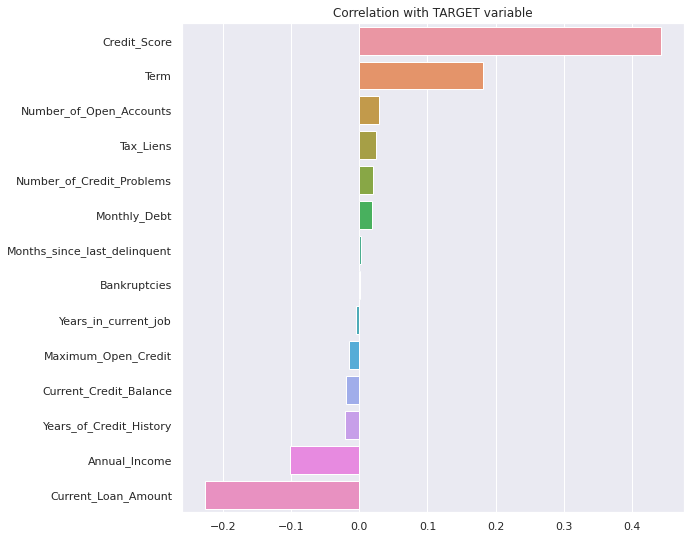

In [ ]:
sns.set(font_scale=1)
corr_with_TARGET = df_train.corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(9, 9))
sns.barplot(x=corr_with_TARGET.values, y=corr_with_TARGET.index)
plt.title('Correlation with TARGET variable')

Линейная корреляция с целевой переменной наблюдается с Credit_Score и Current_Loan_Amount.

## 2. Обработка пропусков.

Найдём все признаки, где отсутсвуют значения.

Text(84.5, 0.5, 'Values')

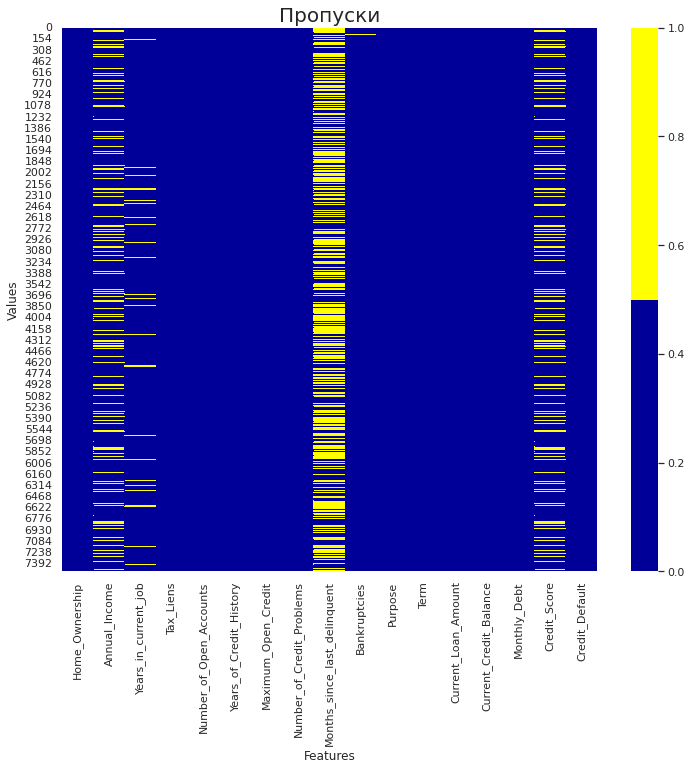

In [ ]:
# определяем цвета 
# желтый - пропущенные данные, синий - не пропущенные

plt.figure(figsize=(12, 10))
colours = ['#000099', '#ffff00'] 
ax = sns.heatmap(df_train[df_train.columns].isnull(), cmap=sns.color_palette(colours))

# Decorations

plt.title('Пропуски', fontsize=20)

plt.xlabel('Features')
plt.ylabel('Values')

In [ ]:
df_train.isna().sum()

Home_Ownership                     0
Annual_Income                   1557
Years_in_current_job             371
Tax_Liens                          0
Number_of_Open_Accounts            0
Years_of_Credit_History            0
Maximum_Open_Credit                0
Number_of_Credit_Problems          0
Months_since_last_delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current_Loan_Amount                0
Current_Credit_Balance             0
Monthly_Debt                       0
Credit_Score                    1557
Credit_Default                     0
dtype: int64

#### Мой вариант подсчёта процентов пропусков

In [ ]:
print(f'Процент пропусков в датафрейме по столбцам\n')
for col in df_train.columns:
  have_null = df_train[col].isna().sum()
  if have_null != 0:
    print(f'{col} - {round(df_train[col].isna().sum() / df_train.shape[0]*100, 2)}%')

Процент пропусков в датафрейме по столбцам

Annual_Income - 20.76%
Years_in_current_job - 4.95%
Months_since_last_delinquent - 54.41%
Bankruptcies - 0.19%
Credit_Score - 20.76%


### Annual_Income 

In [ ]:
Annual_Income_mode = df_train.Annual_Income.mode()[0]
Annual_Income_mode

969475.0

Введём столбец для учёта тех строк, где были отсутствующие значения.

In [ ]:
df_train['Annual_Income_NaN'] = 0
df_train.loc[df_train['Annual_Income'].isna(), 'Annual_Income_NaN'] = 1
# df_train[df_train['Annual_Income_NaN'] == 1].count()

Заполним отсутствующие значения модой.

In [ ]:
df_train.Annual_Income.fillna(Annual_Income_mode, inplace=True)
df_train.Annual_Income.isna().sum()

0

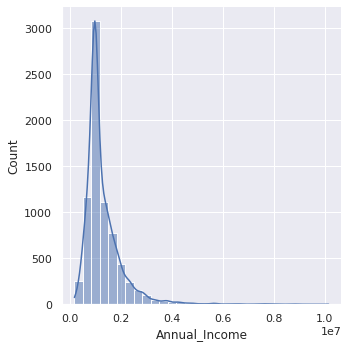

In [ ]:
sns.displot(df_train['Annual_Income'], bins=30, kde=True)

### Years_in_current_job

In [ ]:
df_train['Years_in_current_job_NaN'] = 0
df_train.loc[df_train['Years_in_current_job'].isna(), 'Years_in_current_job_NaN'] = 1

In [ ]:
Years_in_current_job_mod = df_train.Years_in_current_job.mode()[0]
print(Years_in_current_job_mod)

df_train.Years_in_current_job.fillna(Years_in_current_job_mod, inplace=True)
print(df_train.Years_in_current_job.isna().sum())

10.0
0


In [ ]:
df_train.corr()['Years_in_current_job']['Credit_Default']

0.006776090201723654

### Months_since_last_delinquent

Линейная корреляция с целевой переменной мала. И большое количество пропусков. В теории можно удалить.

Но попробуем обработать: предположим, что у тех, у кого нет проблем с кредитами, то можно проставить 0 в значения для месяцев просрочки.

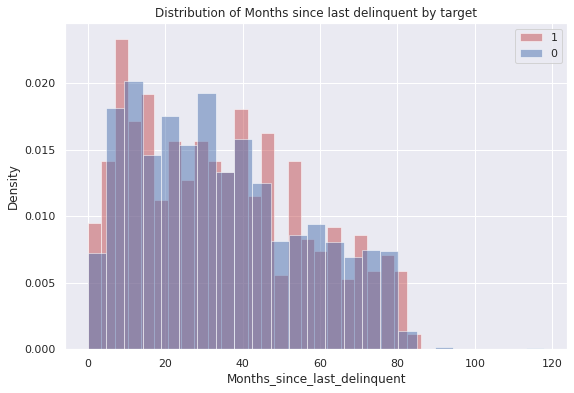

In [ ]:
plt.figure(figsize = (9, 6))

df_train.loc[df_train['Credit_Default'] == 1, 'Months_since_last_delinquent'].hist(bins=25, density=True, color ='r', alpha=0.5, label ='1')
df_train.loc[df_train['Credit_Default'] == 0, 'Months_since_last_delinquent'].hist(bins=25, density=True, color ='b', alpha=0.5, label ='0')
plt.xlabel('Months_since_last_delinquent')
plt.ylabel('Density')
plt.title('Distribution of Months since last delinquent by target')
plt.legend()
plt.show()

Признак не оказывает сильного влияния на целевую переменную и много отсутсвующих значений. Поэтому лучше его убрать из обучения.

### Bankruptcies

Предположим в отсутствующих значениях банкротств, то их просто нет. И заполним значения 0.

In [ ]:
df_train['Bankruptcies_NaN'] = 0
df_train.loc[df_train['Bankruptcies'].isna(), 'Bankruptcies_NaN'] = 1
df_train['Bankruptcies'].fillna(0 , inplace=True)
df_train['Bankruptcies'].isna().sum()

0

### Credit_Score

Заполним отсутствующие значения модой.

In [ ]:
df_train['Credit_Score_NaN'] = 0
df_train.loc[df_train.Credit_Score.isna(), 'Credit_Score_NaN'] = 1

Credit_Score_mode = df_train.Credit_Score.mode()[0]
Credit_Score_mode

df_train.Credit_Score.fillna(Credit_Score_mode, inplace=True)
df_train['Credit_Score'].isna().sum()

0

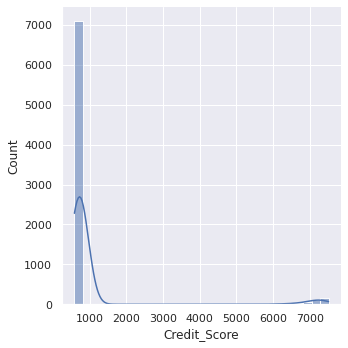

In [ ]:
sns.displot(df_train.Credit_Score, bins=30, kde=True)

## Обработка выбросов.

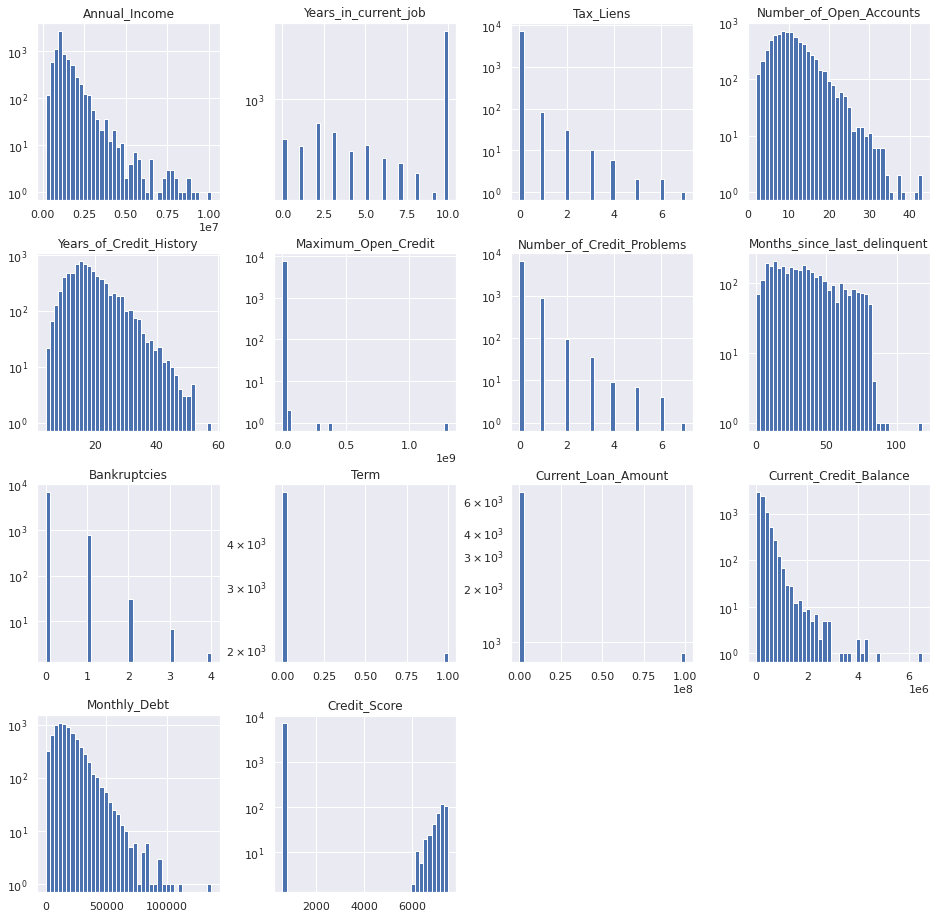

In [ ]:
df_train[feat].hist(bins=40, figsize=(16, 16), log = True)

# Draw plot
plt.show()

### Current_Loan_Amount

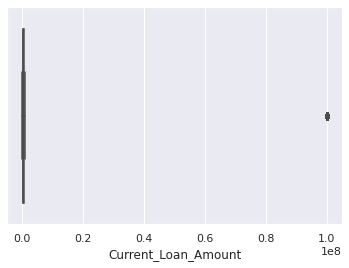

In [ ]:
# Prepare Data
plt.figure(figsize=(6, 4))

# Draw plot
sns.boxplot(x=df_train['Current_Loan_Amount'], whis=1.5, orient='h')

In [ ]:
df_train.loc[df_train.Current_Loan_Amount == 99999999.0, 'Current_Loan_Amount'].value_counts()

99999999.0    870
Name: Current_Loan_Amount, dtype: int64

Наблюдается 870 выбросов со значением 99999999.0. 

Посмотрим на распределение значений в разрезе целевой переменной.

/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


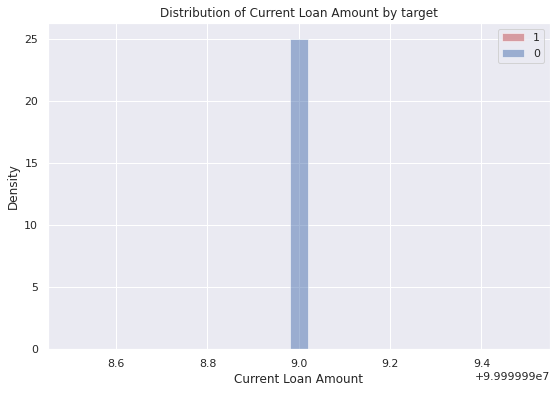

In [ ]:
plt.figure(figsize = (9, 6))

df_train.loc[(df_train['Credit_Default'] == 1) & (df_train['Current_Loan_Amount'] == 99999999.0), 'Current_Loan_Amount'].hist(bins=25, density=True, color ='r', alpha=0.5, label ='1')
df_train.loc[(df_train['Credit_Default'] == 0) & (df_train['Current_Loan_Amount'] == 99999999.0), 'Current_Loan_Amount'].hist(bins=25, density=True, color ='b', alpha=0.5, label ='0')
plt.xlabel('Current Loan Amount')
plt.ylabel('Density')
plt.title('Distribution of Current Loan Amount by target')
plt.legend()
plt.show()

Выбросные значения 99999999.0 имеют значения 0 колонки Credit Default, вероятно, что пользователи с такими значениями не допустили просрочки по кредиту.

In [ ]:
df_train['Current_Loan_Amount'].quantile(.95)

99999999.0

In [ ]:
df_train['Current_Loan_Amount_Outlier'] = 0
df_train.loc[df_train.Current_Loan_Amount >= df_train.Current_Loan_Amount .quantile(.95), 'Current_Loan_Amount_outlier'] = 1

Предположим, что задолженности нет. Поэтому заполним медианой. Либо возможен вариант, что долга фактически нет и можно заполнить нулём.

In [ ]:
df_train['Current_Loan_Amount_Outlier'] = 0
df_train.loc[df_train['Current_Loan_Amount'] == 99999999.0, 'Current_Loan_Amount_Outlier'] = 1
df_train.loc[df_train['Current_Loan_Amount'] == 99999999.0, 'Current_Loan_Amount'] = df_train['Current_Loan_Amount'].median()

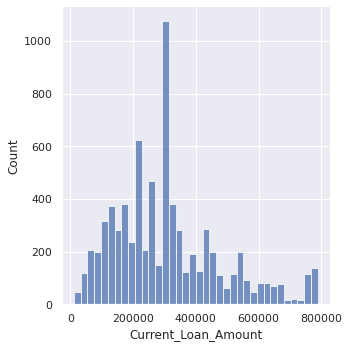

In [ ]:
sns.displot(x=df_train.Current_Loan_Amount)

### Maximum_Open_Credit

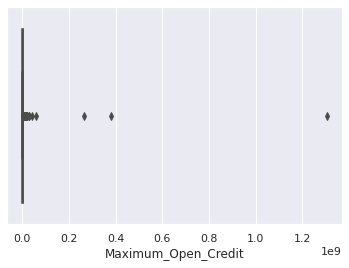

In [ ]:
# Prepare Data
plt.figure(figsize=(6, 4))

# Draw plot
sns.boxplot(x=df_train.Maximum_Open_Credit, whis=1.5, orient='h')

В Current_Loan_Amount максимальным значением было 99999999.0. Примем его за максимум.

In [ ]:
max_credit = 99999999.0

In [ ]:
df_train.loc[df_train['Maximum_Open_Credit'] > max_credit, 'Maximum_Open_Credit'].count()

3

In [ ]:
df_train['Maximum_Open_Credit_Outlier'] = 0
df_train.loc[df_train['Maximum_Open_Credit'] > max_credit, 'Maximum_Open_Credit_Outlier'] = 1
df_train.loc[df_train.Maximum_Open_Credit < df_train.Current_Credit_Balance, 'Maximum_Open_Credit_Outlier'] = 1
df_train.loc[df_train['Maximum_Open_Credit'] > max_credit, 'Maximum_Open_Credit'] = max_credit

Также есть значения, где максимальный кредит меньше размера текущего кредита. Заменим такие значения на Current_Credit_Balance

In [ ]:
df_train.loc[df_train.Maximum_Open_Credit < df_train.Current_Credit_Balance, ['Maximum_Open_Credit', 'Current_Credit_Balance']]

,Maximum_Open_Credit,Current_Credit_Balance
8,0.0,19.0
602,0.0,60439.0
611,0.0,7163.0
1984,0.0,2759503.0
2081,0.0,659471.0
2872,0.0,114.0
3900,0.0,76.0
4256,0.0,19.0
4962,0.0,69084.0
5720,0.0,48545.0


In [ ]:
df_train.loc[df_train.Maximum_Open_Credit < df_train.Current_Loan_Amount, ['Maximum_Open_Credit', 'Current_Loan_Amount']]

,Maximum_Open_Credit,Current_Loan_Amount
8,0.0,129734.0
9,511302.0,572880.0
18,387222.0,553586.0
19,199078.0,309672.0
22,288442.0,309573.0
...,...,...
7485,429154.0,466796.0
7487,232364.0,267982.0
7488,51744.0,129338.0
7491,280170.0,437404.0


In [ ]:
# for label, content in df_train.loc[df_train.Maximum_Open_Credit < df_train.Current_Credit_Balance, ['Maximum_Open_Credit', 'Current_Credit_Balance']].items():
#   print(f'label: {label}')
#   print(f'content: {content}', sep='\n')

In [ ]:
for i in range(0, len(df_train['Maximum_Open_Credit'].values)):
            if df_train['Maximum_Open_Credit'].values[i] <= df_train.Current_Loan_Amount.values[i]:
                df_train['Maximum_Open_Credit'].values[i] = df_train['Current_Loan_Amount'].values[i]

In [ ]:
# for i, row in df.iterrows():
# 	print(f"Index: {i}")
# 	print(f"{row}\n")

### Credit_Score

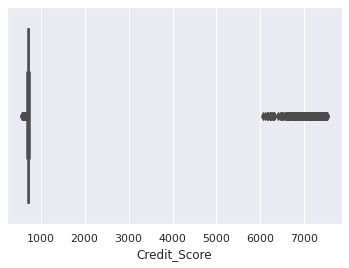

In [ ]:
# Prepare Data
plt.figure(figsize=(6, 4))

# Draw plot
sns.boxplot(x=df_train.Credit_Score, whis=1.5, orient='h')

In [ ]:
df_train[df_train['Credit_Score'] <= 850]['Credit_Score'].count()

7100

In [ ]:
df_train[df_train['Credit_Score'] >= 1000]['Credit_Score'].count()

400

Есть 400 значений в диапазоне [6000, 8000], которые на порядок больше остальных 7100 в диапазоне [500, 750]. Предположим, что кредитный скор основывается на кредитном рейтинге FICO. Разделим значения более 850 на 10.

In [ ]:
df_train['Credit_Score_Outlier'] = 0
df_train.loc[df_train['Credit_Score'] > 1000, 'Credit_Score_Outlier'] = 1
df_train.loc[df_train['Credit_Score'] > 1000, 'Credit_Score'] = df_train.loc[df_train['Credit_Score'] > 1000, 'Credit_Score'] / 10

### Home_Ownership

Home_Ownership - Есть значение Have Mortgage, в котором всего 12 наблюдений (выбросы) и оно очень похоже на Home Mortgage, которое является самым часто встречающимся в датасете. заменим эти значения на mode()

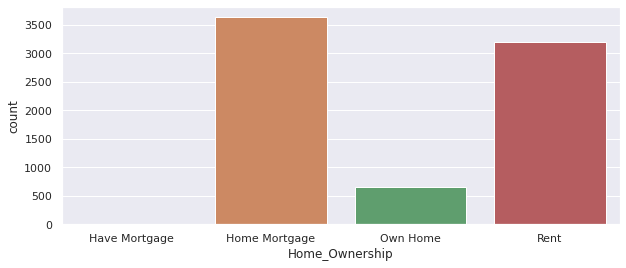

In [ ]:
# Prepare Data
plt.figure(figsize=(10, 4))

# Draw plot
sns.countplot(x=df_train.Home_Ownership)

In [ ]:
df_train[df_train.Home_Ownership == 'Have Mortgage']['Home_Ownership'].count()

12

Have Mortgage - это просто наличие ипотеки. Также как и Home mortgage. Заменим значения на Home mortgage, точнее на моду.

In [ ]:
Home_Ownership_mod = df_train.Home_Ownership.mode()[0]
print(Home_Ownership_mod)

Home Mortgage


In [ ]:
df_train['Home_Ownership_Outlier'] = 0
df_train.loc[df_train['Home_Ownership'] == 'Have Mortgage', 'Home_Ownership_Outlier'] = 1
df_train.loc[df_train['Home_Ownership'] == 'Have Mortgage', 'Home_Ownership'] = Home_Ownership_mod

### Years_of_Credit_History

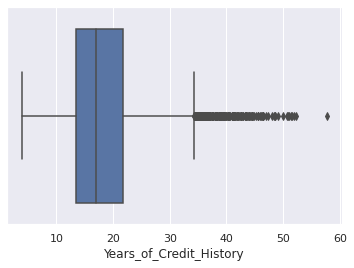

In [ ]:
# Prepare Data
plt.figure(figsize=(6, 4))

# Draw plot
sns.boxplot(x=df_train.Years_of_Credit_History, whis=1.5, orient='h')

In [ ]:
# df_train.Years_of_Credit_History.quantile(0.995)

In [ ]:
df_train[df_train['Years_of_Credit_History'] > 50]

,Home_Ownership,Annual_Income,Years_in_current_job,Tax_Liens,Number_of_Open_Accounts,Years_of_Credit_History,Maximum_Open_Credit,Number_of_Credit_Problems,Months_since_last_delinquent,Bankruptcies,...,Credit_Default,Annual_Income_NaN,Years_in_current_job_NaN,Bankruptcies_NaN,Credit_Score_NaN,Current_Loan_Amount_Outlier,Current_Loan_Amount_outlier,Maximum_Open_Credit_Outlier,Credit_Score_Outlier,Home_Ownership_Outlier
247,Home Mortgage,1893426.0,10.0,0.0,7.0,52.2,711524.0,0.0,NaN,0.0,...,1,0,1,0,0,0,NaN,0,0,0
476,Home Mortgage,1076768.0,10.0,0.0,14.0,57.7,558360.0,0.0,24.0,0.0,...,1,0,1,0,0,0,NaN,0,0,0
3091,Rent,582141.0,10.0,0.0,7.0,50.9,487498.0,0.0,NaN,0.0,...,0,0,1,0,0,1,1.0,0,0,0
3628,Own Home,376314.0,10.0,0.0,8.0,51.3,139436.0,1.0,NaN,1.0,...,0,0,1,0,0,0,NaN,0,0,0
4301,Home Mortgage,969475.0,10.0,0.0,19.0,51.9,1602524.0,0.0,17.0,0.0,...,0,1,1,0,1,0,NaN,0,0,0
4716,Rent,969475.0,10.0,0.0,5.0,51.5,614614.0,0.0,14.0,0.0,...,1,1,1,0,1,0,NaN,0,0,0
5673,Home Mortgage,949810.0,10.0,0.0,15.0,50.6,1180388.0,0.0,71.0,0.0,...,0,0,0,0,0,0,NaN,0,0,0
7251,Home Mortgage,969475.0,10.0,0.0,8.0,51.0,1769900.0,0.0,27.0,0.0,...,1,1,0,0,1,0,NaN,0,0,0


In [ ]:
Years_of_Credit_History_mod = df_train.Years_of_Credit_History.mode()[0]
print(Years_of_Credit_History_mod)

df_train['Years_of_Credit_History_Outlier'] = 0
df_train.loc[df_train['Years_of_Credit_History'] > 50, 'Years_of_Credit_History_Outlier'] = 1
df_train.loc[df_train['Years_of_Credit_History'] > 50, 'Years_of_Credit_History'] = Years_of_Credit_History_mod

15.0


### Monthly_Debt

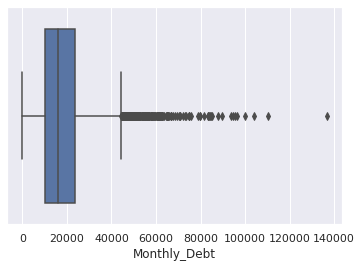

In [ ]:
# Prepare Data
plt.figure(figsize=(6, 4))

# Draw plot
sns.boxplot(x=df_train.Monthly_Debt, whis=1.5, orient='h')

In [ ]:
df_train.Monthly_Debt.quantile(0.999)

91718.35100000429

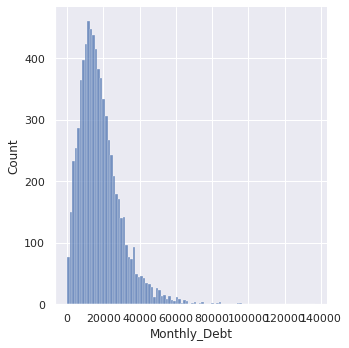

In [ ]:
sns.displot(x=df_train.Monthly_Debt)

In [ ]:
df_train.Monthly_Debt.median()

16076.5

In [ ]:
df_train['Monthly_Debt'].mode()

0    0.0
dtype: float64

In [ ]:
df_train[df_train.Monthly_Debt == 0]['Monthly_Debt']

780     0.0
1643    0.0
3219    0.0
3496    0.0
4165    0.0
7124    0.0
Name: Monthly_Debt, dtype: float64

In [ ]:
df_train.loc[(df_train.Monthly_Debt > 16000) & (df_train.Monthly_Debt < 16700), 'Monthly_Debt']

65      16428.0
82      16606.0
98      16251.0
101     16645.0
133     16441.0
         ...   
7399    16199.0
7416    16683.0
7461    16225.0
7475    16473.0
7481    16380.0
Name: Monthly_Debt, Length: 204, dtype: float64

In [ ]:
Monthly_Debt_med = df_train.Monthly_Debt.median()
print(Monthly_Debt_med)

df_train['Monthly_Debt_Outlier'] = 0
df_train.loc[df_train['Monthly_Debt'] > df_train.Monthly_Debt.quantile(0.999), 'Monthly_Debt_Outlier'] = 1
df_train.loc[df_train['Monthly_Debt'] > df_train.Monthly_Debt.quantile(0.999), 'Monthly_Debt'] = Monthly_Debt_med

16076.5


## EDA

### Purpose 

**Оценка признака "PAY_1" в разрезе целевой переменной**

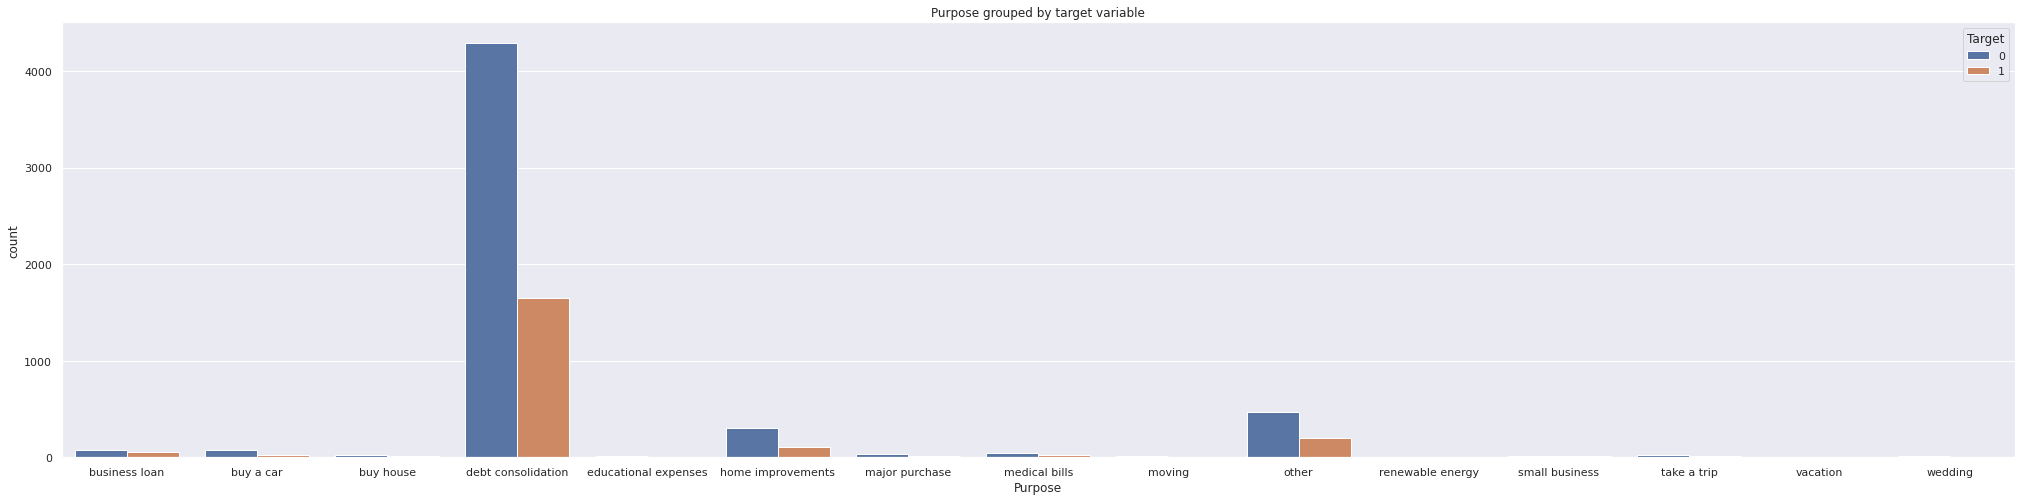

In [ ]:
plt.figure(figsize=(35, 8))

sns.countplot(x="Purpose", hue=target, data=df_train)
plt.title('Purpose grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [ ]:
df = df_train.copy()
variable_name = 'Purpose'
df['ID'] = df.index

In [ ]:
purpose_target = df[['ID', 'Purpose', 'Credit_Default']]

table = purpose_target.pivot_table(columns='Credit_Default', index='Purpose', values='ID', aggfunc='count')
table.columns.to_list()
table['devide'] = table[0] / table[1]
table

Credit_Default,0,1,devide
Purpose,,,
business loan,74.0,55.0,1.345455
buy a car,72.0,24.0,3.000000
buy house,25.0,9.0,2.777778
debt consolidation,4290.0,1654.0,2.593712
educational expenses,9.0,1.0,9.000000
home improvements,304.0,108.0,2.814815
major purchase,31.0,9.0,3.444444
medical bills,49.0,22.0,2.227273
moving,9.0,2.0,4.500000


**Наблюдение**

Изучив получившийся график, видно, что значения wedding, признака PAY_1 имеют схожие доли в разрезе целевой переменной. Если это действительно так, то можно будет, например, объединить их в одну категорию.

**Гипотеза** 

* Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы
* Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
* Критерий: Хи-квадрат Пирсона
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Для проверки данной гипотезы необходимо подать наблюдаемые частоты категорий -1 и 0 признака PAY_1 в выбранный критерий, после чего оценить значение достигаемого уровня значимости p-value и сравнить с его с выбранным порогом альфа, если p-value получится больше выбранного порога, то гипотезу о согласованности частот можно не отбрасывать.

In [ ]:
df = df_train.copy()
variable_name = 'Purpose'
df['index'] = df.index

purpose_and_target_x = df.loc[df['Purpose'].isin(['take a trip', 'debt consolidation', 'wedding',  'buy house', 'home improvements', 'buy a car',  'vacation', 'medical bills']), ['index', 'Purpose', 'Credit_Default']]
# purpose_and_target_x
table_p = purpose_and_target_x.pivot_table(columns='Credit_Default', index=purpose_and_target_x.Purpose, values='index', aggfunc='count')
table_p

Credit_Default,0,1
Purpose,,
buy a car,72,24
buy house,25,9
debt consolidation,4290,1654
home improvements,304,108
medical bills,49,22
take a trip,27,10
vacation,6,2
wedding,11,4


In [ ]:
chi2, p, dof, expected = chi2_contingency(table_p, correction=False)
p

0.9882982010763037

### Tax_Liens

Рассмотрим распределение признака в разрезе целевой переменной.

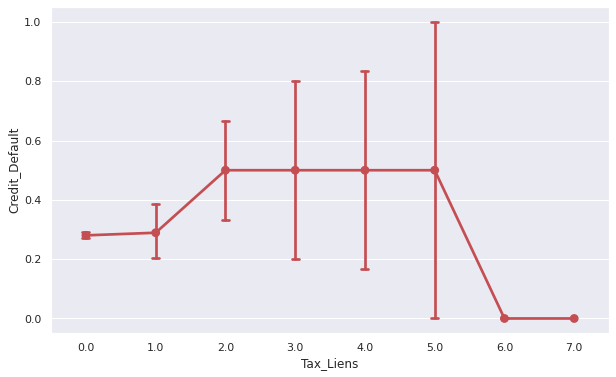

In [ ]:
plt.figure(figsize=(10, 6))
sns.pointplot(x=df_train.Tax_Liens, y=col, data=df_train, capsize=.1, label='train', color='r')

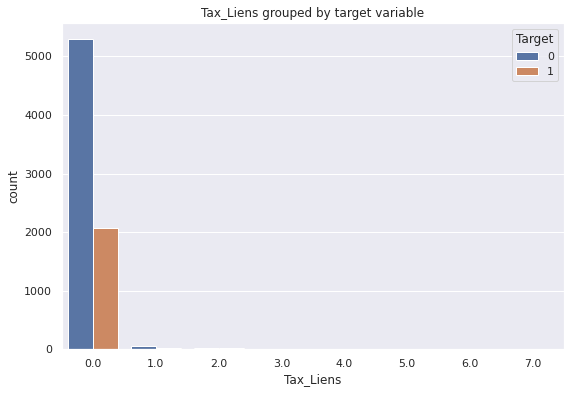

In [ ]:
plt.figure(figsize=(9, 6))

sns.countplot(x='Tax_Liens', hue='Credit_Default', data=df_train)
plt.title('Tax_Liens grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [ ]:
df = df_train.copy()
variable_name = 'Tax_Liens'
df['index'] = df.index

In [ ]:
variable_and_target = df.loc[df[variable_name].isin([0, 1]), ['Id', variable_name, TARGET_NAME]]
table = variable_and_target.pivot_table(values='Id', index=variable_name, columns=TARGET_NAME, aggfunc='count')
table

NameError: ignored

In [ ]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=target, y='Tax_Liens', data=df_train, capsize=.1)

plt.title('Confidence intervals (95 %) for Tax_Liens')
plt.show()

Посмотрим на признак 'Years in current job' в разрезе целевой переменной

In [ ]:
plt.figure(figsize=(9, 6))

sns.countplot(x='Years_in_current_job', hue='Credit_Default', data=df_train)
plt.title('Years in current job grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [ ]:
df_train['Index'] = df_train.index
years_target = df_train[['Index', 'Years_in_current_job', 'Credit_Default']]

t = years_target.pivot_table(columns='Credit_Default', index='Years_in_current_job', values='Index', aggfunc='count')
t.columns.to_list()
t['devide'] = t[0]/t[1]
t

In [ ]:
df_train.groupby('Years_in_current_job')['Credit_Default'].mean().sort_values()

In [ ]:
# df_train.groupby('Years_in_current_job').head()

In [ ]:
df_train['Index'] = df_train.index
years_target = df_train[['Index', 'Years_in_current_job', 'Credit_Default']]

table = years_target.pivot_table(columns='Credit_Default', index='Years_in_current_job', values='Index', aggfunc='count')
t.columns.to_list()
t['devide'] = t[0]/t[1]
t

In [ ]:
years_and_target_s = df_train.loc[df_train['Years_in_current_job'].isin([0, 1]), ['Index', 'Years_in_current_job', 'Credit_Default']]

In [ ]:
table = years_and_target_s.pivot_table(values='Index', index='Years_in_current_job', columns='Credit_Default', aggfunc='count')
table

In [ ]:
from scipy.stats import chi2_contingency

In [ ]:
chi2, p, _, _ = chi2_contingency(table)
p

In [ ]:
chi2, p, dof, expected = chi2_contingency(t, correction=False)
p